<a href="https://colab.research.google.com/github/1oneweeek/Pyt_MCL/blob/Main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VAE: Variational Autoencoder. 오토인코더의 확장된 형태로 데이터의 잠재적인 분포를 학습하여 새로운 데이터를 생성하는 데 사용됨.

1. 인코더(Encoder)

입력 데이터는 주로 고차원 벡터로 인코더는 입력 데이터를 저차원의 잠재 공간으로 매핑함.
이 때 잠재 공간에서 데이터 분포의 모양을 결정하는데 사용되는 잠재 변수의 평균과 분산으로 입력 데이터를 매핑함.

2. 디코더(Decoder)

잠재 공간의 샘플을 실제 데이터로 복원함. 인코더와 반대로 디코더는 잠재 공간에서 샘플링된 벡터를 고차원의 데이터로 매핑함.

In [ ]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from torch import distributions

# 인코더: 입력 이미지를 잠재 공간의 확률 분포로 매핑
# 입력 이미지가 신경망을 통해 잠재 공간의 평균과 표준편차를 나타내는 파라미터로 변환됨
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, latent_size): # 입력데이터차원, 은닉층크기, 잠재공간크기
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.enc_mu = torch.nn.Linear(H, latent_size)
        self.enc_log_sigma = torch.nn.Linear(H, latent_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.enc_mu(x) # 잠재 변수의 평균
        log_sigma = self.enc_log_sigma(x) # 로그 표준 편차
        sigma = torch.exp(log_sigma)
        return torch.distributions.Normal(loc=mu, scale=sigma) # 정규 분포 객체 반환

# 디코더: 잠재 공간의 변수를 다시 원래 이미지 공간으로 변환
# 잠재 공간의 변수를 입력으로 받아 이미지를 생성하는 역할
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out): # 입력데이터차원, 은닉층크기, 출력데이터크기
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)


    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu = torch.tanh(self.linear2(x)) # 이미지 픽셀값 범위 조절을 위해 tanh 활성화 함수가 적용된 출력 반환
        return torch.distributions.Normal(mu, torch.ones_like(mu)) # 정규 분포 객체 반환

# 인코더와 디코더를 결합한 모델
# 주어진 입력 이미지를 인코더로 전달하여 잠재 공간의 분포를 얻고
# 이를 토대로 잠재 변수를 샘플링해 디코더로 전달
class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, state):
        q_z = self.encoder(state) # 잠재 변수의 분포
        z = q_z.rsample()
        return self.decoder(z), q_z

# 이미지 데이터 변환
transform = transforms.Compose(
    [transforms.ToTensor(),
     # Normalize the images to be -0.5, 0.5
     transforms.Normalize(0.5, 1)]
    )
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

# 하이퍼파라미터 설정
input_dim = 28 * 28
batch_size = 128
num_epochs = 100
learning_rate = 0.001
hidden_size = 512
latent_size = 8

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available())

print('Number of samples: ', len(mnist))

encoder = Encoder(input_dim, hidden_size, latent_size)
decoder = Decoder(latent_size, hidden_size, input_dim)

# VAE 모델 생성
vae = VAE(encoder, decoder).to(device)

# Adam 옵티마이저를 사용하여 VAE 모델의 하이퍼파라미터 최적화
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# VAE 모델 학습
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data # 미니배치로부터 입력 데이터를 가져옴
        inputs = inputs.view(-1, input_dim).to(device)# 입력이미지를 flatten하여 1차원으로 변환
        optimizer.zero_grad() # 그래디언트 초기화
        p_x, q_z = vae(inputs) # p_x: 복원된 이미지, q_z: 잠재 변수의 분포

        # 로그 우도: 주어진 데이터에 대한 확률 모델의 적합도를 나타내는 척도
        log_likelihood = p_x.log_prob(inputs).sum(-1).mean() # p_x의 로그 우도 계산
        # 확률 모델이 주어진 데이터를 얼마나 잘 설명하는지를 측정하는 지표로 높을수록 좋음
        # 여기서는 원본 이미지가 모델이 생성한 이미지와 얼마나 일치하는지를 나타냄

        # KL 발산: 두 확률 분포 간의 차이를 측정하는 방법 중 하나
        # 두 확률 분포 P와 Q 사이의 KL발산: P를 Q에 대해 얼마나 설명할 수 있는지를 나타내는 값
        # 즉 두 확률 분포가 얼마나 다른지를 측정하는 지표로 클수록 다름 -> 낮은 KL발산을 원함
        # 잠재 변수의 분포와 표준 정규 분포 간의 KL 발산 계산
        kl = torch.distributions.kl_divergence(
            q_z,
            torch.distributions.Normal(0, 1.)
        ).sum(-1).mean()
        # 잠재 변수의 분포와 표준 정규 분포(Normal(0, 1)) 간의 KL 발산을 계산
        # 이는 VAE가 잠재 변수를 표준 정규 분포에 가깝게 만드려고 함을 의미
        # 이로써 잠재 공간을 unit Gaussian으로 만들어서 샘플링하기 쉽게함

        # ELBO(Evidence Lower Bound) loss 계산
        # ELBO: VAE에서 사용되는 loss함수
        # ELBO 최대화: 로그 우도는 높이고 KL 발산은 낮춤
        # -> 데이터를 잘 생성하고 모델을 단순화하는 효과
        loss = -(log_likelihood - kl)
        loss.backward() # 역전파 수행, 그래디언트 계산
        optimizer.step() # 옵티마이저 사용, 모델 파라미터 업데이트
        l = loss.item() # loss값 추출
    print(epoch, l, log_likelihood.item(), kl.item())

Number of samples:  60000
0 741.9196166992188 -737.6917724609375 4.2278594970703125
1 740.8565673828125 -736.1591796875 4.697403430938721
2 740.7950439453125 -736.0062255859375 4.788819313049316
3 740.1312255859375 -734.6908569335938 5.440371513366699
4 740.0304565429688 -734.688232421875 5.342232704162598
5 740.2371826171875 -734.487060546875 5.750129699707031
6 739.45556640625 -733.835205078125 5.620336532592773
7 739.9994506835938 -734.3338623046875 5.665594100952148
8 739.4932861328125 -733.7562255859375 5.7370710372924805
9 739.958251953125 -734.4661865234375 5.49208927154541
10 740.484130859375 -734.3486328125 6.135476589202881
11 739.2024536132812 -733.2355346679688 5.966921806335449
12 741.1431274414062 -735.1522216796875 5.9908905029296875
13 739.8585205078125 -734.0192260742188 5.839300155639648
14 739.6842651367188 -733.7077026367188 5.976565361022949
15 739.9708862304688 -734.0989990234375 5.871910095214844
16 739.3278198242188 -733.141357421875 6.186489105224609
17 738.601

In [ ]:
losses = []  # 손실값을 저장하는 리스트
log_likelihoods = []  # 로그 우도를 저장하는 리스트
kl_divergences = []  # KL 발산을 저장하는 리스트

for epoch in range(num_epochs):
    total_loss = 0.0
    total_log_likelihood = 0.0
    total_kl_divergence = 0.0

    for data in dataloader:
        inputs, _ = data
        inputs = inputs.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        p_x, q_z = vae(inputs)
        log_likelihood = p_x.log_prob(inputs).sum(-1).mean()
        kl = torch.distributions.kl_divergence(
            q_z,
            torch.distributions.Normal(0, 1.)
        ).sum(-1).mean()
        loss = -(log_likelihood - kl)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_log_likelihood += log_likelihood.item()
        total_kl_divergence += kl.item()

    # 각 에포크마다의 평균 손실, 로그 우도, KL 발산을 계산하여 리스트에 추가
    avg_loss = total_loss / len(dataloader)
    avg_log_likelihood = total_log_likelihood / len(dataloader)
    avg_kl_divergence = total_kl_divergence / len(dataloader)

    losses.append(avg_loss)
    log_likelihoods.append(avg_log_likelihood)
    kl_divergences.append(avg_kl_divergence)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}, Log Likelihood: {avg_log_likelihood}, KL Divergence: {avg_kl_divergence}")


Epoch [1/100], Loss: 739.1103419322195, Log Likelihood: -732.7586689442713, KL Divergence: 6.351672411473321
Epoch [2/100], Loss: 739.0935753535614, Log Likelihood: -732.730200143257, KL Divergence: 6.363374508774357
Epoch [3/100], Loss: 739.0772231372434, Log Likelihood: -732.7337386206523, KL Divergence: 6.34348383132837
Epoch [4/100], Loss: 739.0809146580157, Log Likelihood: -732.7216139673424, KL Divergence: 6.359301299682812
Epoch [5/100], Loss: 739.0676196653452, Log Likelihood: -732.7203218179471, KL Divergence: 6.347297719292549
Epoch [6/100], Loss: 739.0918691021038, Log Likelihood: -732.7257500426856, KL Divergence: 6.366119464069033
Epoch [7/100], Loss: 739.0839946559752, Log Likelihood: -732.7239867903785, KL Divergence: 6.360008710482989
Epoch [8/100], Loss: 739.0528102459938, Log Likelihood: -732.7165933377199, KL Divergence: 6.336217876182182
Epoch [9/100], Loss: 739.0823987623268, Log Likelihood: -732.7092445227129, KL Divergence: 6.373152509172842
Epoch [10/100], Loss:

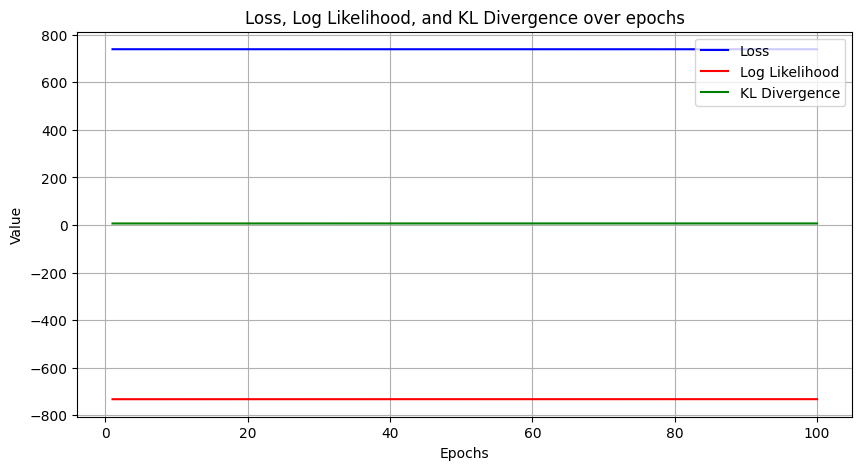

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 5))

# Loss 그래프
plt.plot(epochs, losses, 'b', label='Loss')

# 로그 우도 그래프
plt.plot(epochs, log_likelihoods, 'r', label='Log Likelihood')

# KL 발산 그래프
plt.plot(epochs, kl_divergences, 'g', label='KL Divergence')

plt.title('Loss, Log Likelihood, and KL Divergence over epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()